# Horizontal divergence

In [1]:
# %run _setup.py
import os

import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import numpy as np
import xgcm

from gsw import sigma0, SA_from_SP, p_from_z

from oceanpy import define_grid, horizontal_divergence, Contour, haversine
import pyproj

import matplotlib.pyplot as plt
import cmocean as cmo
import string

In [2]:
figsdir = os.path.join(os.sep, 'g', 'data', 'jk72', 'jm6603', 'checkouts', 'phd-figs', 'manuscripts', '02_manuscript')
savefig=False

fs_small = 22
fs_large = 24

plt.rc('xtick',labelsize=fs_small)
plt.rc('ytick',labelsize=fs_small)
plt.rc('axes', labelsize=fs_large)
plt.rcParams.update({"text.usetex": True, "font.family": 'serif', "font.serif": 'cm', 'font.size': fs_small})
plt.rc('text.latex', preamble=r'\usepackage{xfrac}\usepackage{amsmath}\usepackage{amsfonts}\usepackage{amssymb}')

In [3]:
def coord_cross(along_section, coord_sel):
    idx = np.argmin([haversine([ln, coord_sel[0]], [lt, coord_sel[1]])[0]
                     for ln, lt in zip(along_section.xt_ocean, along_section.yt_ocean)])
    return along_section['along-section'][idx]

In [4]:
database = '/g/data/ik11/databases/cosima_master.db'
session = cc.database.create_session(db=database)

expt = '01deg_jra55v140_iaf'

In [5]:
client = Client(threads_per_worker=1, memory_limit=0)
client.amm.start()

## Load data

In [6]:
# data output frequency
freq = '1 daily'

# time limits of dataset
start, end = '1997-04-01', '1997-04-30'
time_lim = slice(start, end)

In [7]:
# load variables 
sl = cc.querying.getvar(expt=expt, variable='sea_level', session=session, frequency=freq, start_time=start, end_time=end)
u = cc.querying.getvar(expt=expt, variable='u', session=session, frequency=freq, start_time=start, end_time=end)
v = cc.querying.getvar(expt=expt, variable='v', session=session, frequency=freq, start_time=start, end_time=end)
wt = cc.querying.getvar(expt=expt, variable='wt', session=session, frequency=freq, start_time=start, end_time=end)

temp = cc.querying.getvar(expt=expt, variable='temp', session=session, frequency=freq, start_time=start, end_time=end)
salt = cc.querying.getvar(expt=expt, variable='salt', session=session, frequency=freq, start_time=start, end_time=end)

# load coordinates
dxt = cc.querying.getvar(expt=expt, variable='dxt', session=session, frequency='static', n=1)
dyt = cc.querying.getvar(expt=expt, variable='dyt', session=session, frequency='static', n=1)
dzt = cc.querying.getvar(expt=expt, variable='dzt', session=session, frequency='1 monthly', n=1)

dxu = cc.querying.getvar(expt=expt, variable='dxu', session=session, frequency='static', n=1)
dyu = cc.querying.getvar(expt=expt, variable='dyu', session=session, frequency='static', n=1)

area_t = cc.querying.getvar(expt=expt, variable='area_t', session=session, frequency='static', n=1)
area_u = cc.querying.getvar(expt=expt, variable='area_u', session=session, frequency='static', n=1)

# lont = cc.querying.getvar(expt=expt, variable='geolon_t', session=session, frequency='static', n=1)
# latt = cc.querying.getvar(expt=expt, variable='geolat_t', session=session, frequency='static', n=1)

# lonu = cc.querying.getvar(expt=expt, variable='geolon_c', session=session, frequency='static', n=1)
# latu = cc.querying.getvar(expt=expt, variable='geolat_c', session=session, frequency='static', n=1)

# kmt = cc.querying.getvar(expt=expt, variable='kmt', session=session, frequency='static', n=1)
# kmu = cc.querying.getvar(expt=expt, variable='kmu', session=session, frequency='static', n=1)

geolat_t = cc.querying.getvar(expt,'geolat_t', session=session, n=1)
geolon_t = cc.querying.getvar(expt,'geolon_t', session=session, n=1)

# load topography
ht = cc.querying.getvar(expt=expt, variable='ht', session=session, frequency='static', n=1)

## Select regional data

In [8]:
# location limits of dataset
lon_lim = slice(-224.2, -212.5)
lat_lim = slice(-53.5, -47.5)
flex_period = slice('1997-04-10', '1997-04-25')

# select spatial area
sl_lim = sl.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
u_lim = u.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)
v_lim = v.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)
wt_lim = wt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
# wt_ekm_lim = wt_ekm.sel(xt_ocean=lon_lim, yu_ocean=lat_lim)

temp_lim = temp.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
salt_lim = salt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

lat_t = geolat_t.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
lon_t = geolon_t.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

dxt_lim = dxt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
dyt_lim = dyt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
dzt_lim = dzt.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

dxu_lim = dxu.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)
dyu_lim = dyu.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)

areat_lim = area_t.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
areau_lim = area_u.sel(xu_ocean=lon_lim, yu_ocean=lat_lim)

ht_lim = ht.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

# lont_lim = lon.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)
# latt_lim = lat.sel(xt_ocean=lon_lim, yt_ocean=lat_lim)

## Define Grid

In [9]:
# merge variables in dataset
# ds = xr.merge([u_lim, v_lim, dxt_lim, dyt_lim])
# ds = xr.merge([u_lim, v_lim, dxt_lim, dyt_lim, dxu_lim, dyu_lim])

ds = xr.merge([dxt_lim, dyt_lim, dxu_lim, dyu_lim, areat_lim, areau_lim, ht_lim])
ds = xr.merge([ds, sl_lim.sel(time=flex_period), 
               u_lim.sel(time=flex_period), v_lim.sel(time=flex_period),
               wt_lim.sel(time=flex_period)])

coords = {'xt_ocean': None, 'yt_ocean': None, 'st_ocean': None, 'xu_ocean': 0.5, 'yu_ocean': 0.5, 'sw_ocean': 0.5}
distances=('dxt', 'dyt', 'dzt', 'dxu', 'dyu')
areas=('area_u', 'area_t')
dims=('X', 'Y', 'S')

grid = define_grid(ds, dims, coords, distances, areas, periodic=False)
grid

<xgcm.Grid>
S Axis (not periodic, boundary='extend'):
  * center   st_ocean --> right
  * right    sw_ocean --> center
Y Axis (not periodic, boundary='extend'):
  * center   yt_ocean --> inner
  * inner    yu_ocean --> center
X Axis (not periodic, boundary='extend'):
  * center   xt_ocean --> right
  * right    xu_ocean --> center

## Calculate GSW variables

In [10]:
hydro = xr.merge([temp_lim, salt_lim])
hydro = hydro.sel(time=flex_period)

In [11]:
st_ocean = hydro.st_ocean.values
yt_ocean = hydro.yt_ocean.values
xt_ocean = hydro.xt_ocean.values
time = hydro.time.values

lat_t_3d = np.broadcast_to(lat_t, st_ocean.shape + (lat_t.shape))
z_3d = np.broadcast_to(-st_ocean, lat_t_3d.T.shape).T

pressure = xr.DataArray(p_from_z(z_3d, lat_t_3d), 
                        coords = [st_ocean, yt_ocean, xt_ocean], 
                        dims = ['st_ocean', 'yt_ocean', 'xt_ocean'],
                        name = 'pressure',
                        attrs = {'standard_name': 'sea_water_pressure', 'units':'dbar'})
SA = xr.DataArray(SA_from_SP(hydro.salt, pressure, lon_t, lat_t), 
                  coords = [time, st_ocean, yt_ocean, xt_ocean], 
                  dims = ['time', 'st_ocean', 'yt_ocean', 'xt_ocean'], 
                  name = 'SA', 
                  attrs = {'standard_name': 'sea_water_absolute_salinity', 'units':'g kg-1'})

CT = hydro.temp-273
CT.name = 'CT'
CT.attrs.update(units='degC')

sig0 = sigma0(SA, CT)
sig0.name = 'sigma0'
sig0.attrs.update(standard_name='sea_water_potential_density')
sig0.attrs.update(units='kg m-3')

# density contours
watermass = {
    'ML': (np.nan, 26.75),
    'SAMW': (26.75, 26.95),
    'AAIW': (26.95, 27.25, 27.5),
    'UCDW': (27.5, 27.75),
    'LCDW': (27.75, 28.27),
    'AABW': (28.27, 28.5) # water with a <0 potential temperature
}
density_levels = np.unique(np.concatenate([value for value in watermass.values()]))

# mid_density_levels=(density_levels[:-1] + density_levels[1:])/2

In [12]:
hydro

<xarray.Dataset>
Dimensions:   (xt_ocean: 117, yt_ocean: 95, st_ocean: 75, time: 16)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -224.1 -224.0 -223.9 ... -212.7 -212.6 -212.5
  * yt_ocean  (yt_ocean) float64 -53.49 -53.43 -53.37 ... -47.66 -47.59 -47.52
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) datetime64[ns] 1997-04-10T12:00:00 ... 1997-04-25T12:00:00
Data variables:
    temp      (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 19, 66, 117), meta=np.ndarray>
    salt      (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 19, 66, 117), meta=np.ndarray>
Attributes: (12/14)
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    ...             ...
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2020-06-09
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Source code: https://github.com/COSIMA/access-om2 License...

In [13]:
core_contour = -0.4

ut_contours = np.linspace(-0.1, 0.7, 5)

sl_contours = [core_contour-0.2, core_contour, core_contour+0.2]
slc = slice(None, None, 2)

## Horizontal divergence from total velocities in model

In [14]:
ds

<xarray.Dataset>
Dimensions:    (xt_ocean: 117, yt_ocean: 95, xu_ocean: 117, yu_ocean: 94,
                time: 16, st_ocean: 75, sw_ocean: 75)
Coordinates:
  * xt_ocean   (xt_ocean) float64 -224.1 -224.0 -223.9 ... -212.7 -212.6 -212.5
  * yt_ocean   (yt_ocean) float64 -53.49 -53.43 -53.37 ... -47.66 -47.59 -47.52
  * xu_ocean   (xu_ocean) float64 -224.2 -224.1 -224.0 ... -212.8 -212.7 -212.6
  * yu_ocean   (yu_ocean) float64 -53.46 -53.4 -53.34 ... -47.69 -47.62 -47.56
  * time       (time) datetime64[ns] 1997-04-10T12:00:00 ... 1997-04-25T12:00:00
  * st_ocean   (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * sw_ocean   (sw_ocean) float64 1.083 2.279 3.601 ... 5.61e+03 5.809e+03
Data variables:
    dxt        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 117), meta=np.ndarray>
    dyt        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 117), meta=np.ndarray>
    dxu        (yu_ocean, xu_ocean) float32 dask.array<chunksize=(94, 117), meta=np.ndarray>
    dyu        (yu_ocean, xu_ocean) float32 dask.array<chunksize=(94, 117), meta=np.ndarray>
    area_t     (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 117), meta=np.ndarray>
    area_u     (yu_ocean, xu_ocean) float32 dask.array<chunksize=(94, 117), meta=np.ndarray>
    ht         (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 117), meta=np.ndarray>
    sea_level  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 95, 117), meta=np.ndarray>
    u          (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 19, 66, 117), meta=np.ndarray>
    v          (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 19, 66, 117), meta=np.ndarray>
    wt         (time, sw_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 19, 66, 117), meta=np.ndarray>
Attributes:
    long_name:     ocean dxt on t-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    coordinates:   geolon_t geolat_t
    ncfiles:       ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_j...
    contact:       Andrew Kiss
    email:         andrew.kiss@anu.edu.au
    created:       2020-06-09
    description:   0.1 degree ACCESS-OM2 global model configuration under int...
    notes:         Source code: https://github.com/COSIMA/access-om2 License:...

In [15]:
divu = horizontal_divergence(ds, grid, delta_names=('dxt', 'dyt'))
divu.name = 'divu'
divu.attrs['long_name'] = r"$\nabla_h \cdot {\bf u}$"

In [16]:
u_grd = grid.interp(grid.interp(ds.u, 'X'), 'Y')
v_grd = grid.interp(grid.interp(ds.v, 'X'), 'Y')
divu_grd = grid.interp(grid.interp(divu, 'X'), 'Y')

w_grd = grid.interp(ds.wt, 'S')
u_grd.name, v_grd.name, w_grd.name = 'u', 'v', 'wt'
ds['u'], ds['v'], ds['divu'], ds['wt'], ds['wt_inv'] = u_grd, v_grd, divu_grd, w_grd, -w_grd

In [17]:
ds = xr.merge([ds, sig0])
ds = ds.sel(time=flex_period).mean('time')
ds = ds.drop_vars(['dxt', 'dyt', 'dxu', 'dyu', 'area_t', 'area_u', 'xu_ocean', 'yu_ocean', 'sw_ocean'])
ds = ds.sel(xt_ocean=slice(-224, -212))
ds = ds.assign_coords(xt_ocean=((ds.xt_ocean + 180) % 360) - 180)

In [18]:
cont = Contour(ds, coords=('xt_ocean', 'yt_ocean'))
cont.get_coords(contour_name='sea_level', contour_value=core_contour, interp=True, spacing=20000)

# along contour section
along_section = cont.along_section(var_name=('u', 'v'), coords=('xt_ocean', 'yt_ocean'), 
                                   section_name='along-section', decompose=True)

cross_sections = {
    'cross_section_trough': (-222.55, -50.4), 
    'cross_section_trough2': (-222.2, -50.0), 
    'cross_section_trough3': (-220.95, -50), 
    'cross_section_between': (-219.7, -50.25), 
    'cross_section_between2': (-219, -51), 
    'cross_section_between3': (-219, -51.7), 
    'cross_section_crest': (-217.6, -51.8),
    'cross_section_crest2': (-215.8, -51.5),
    'cross_section_crest3': (-214.5, -51)
}

cross_coords = {
    'cross_section_trough' : [coord_cross(along_section, cross_sections['cross_section_trough']), 'tab:blue', ':'], 
    'cross_section_trough2' : [coord_cross(along_section, cross_sections['cross_section_trough2']), 'tab:blue', '-'], 
    'cross_section_trough3' : [coord_cross(along_section, cross_sections['cross_section_trough3']), 'tab:blue', '--'], 
    'cross_section_between' : [coord_cross(along_section, cross_sections['cross_section_between']), 'tab:orange', ':'],
    'cross_section_between2' : [coord_cross(along_section, cross_sections['cross_section_between2']), 'tab:orange', '-'],
    'cross_section_between3' : [coord_cross(along_section, cross_sections['cross_section_between3']), 'tab:orange', '--'],
    'cross_section_crest' : [coord_cross(along_section, cross_sections['cross_section_crest']), 'tab:green', ':'],
    'cross_section_crest2' : [coord_cross(along_section, cross_sections['cross_section_crest2']), 'tab:green', '-'],
    'cross_section_crest3' : [coord_cross(along_section, cross_sections['cross_section_crest3']), 'tab:green', '--']
}

UTM54 = pyproj.Proj('EPSG:32754')
npnts = 10
spacing = 20000 # m
for section, coord in cross_sections.items():
    cross_sections[section] = cont.cross_section(
        coord_sel=coord, transform=UTM54, npnts=npnts, spacing=spacing,
        coords=('xt_ocean', 'yt_ocean'), var_name=('u', 'v'), decompose=True)


In [50]:
wt_contours = np.linspace(-5, 5, 6)
w_levels = np.linspace(-1, 1, 5)

array([-1,  1])

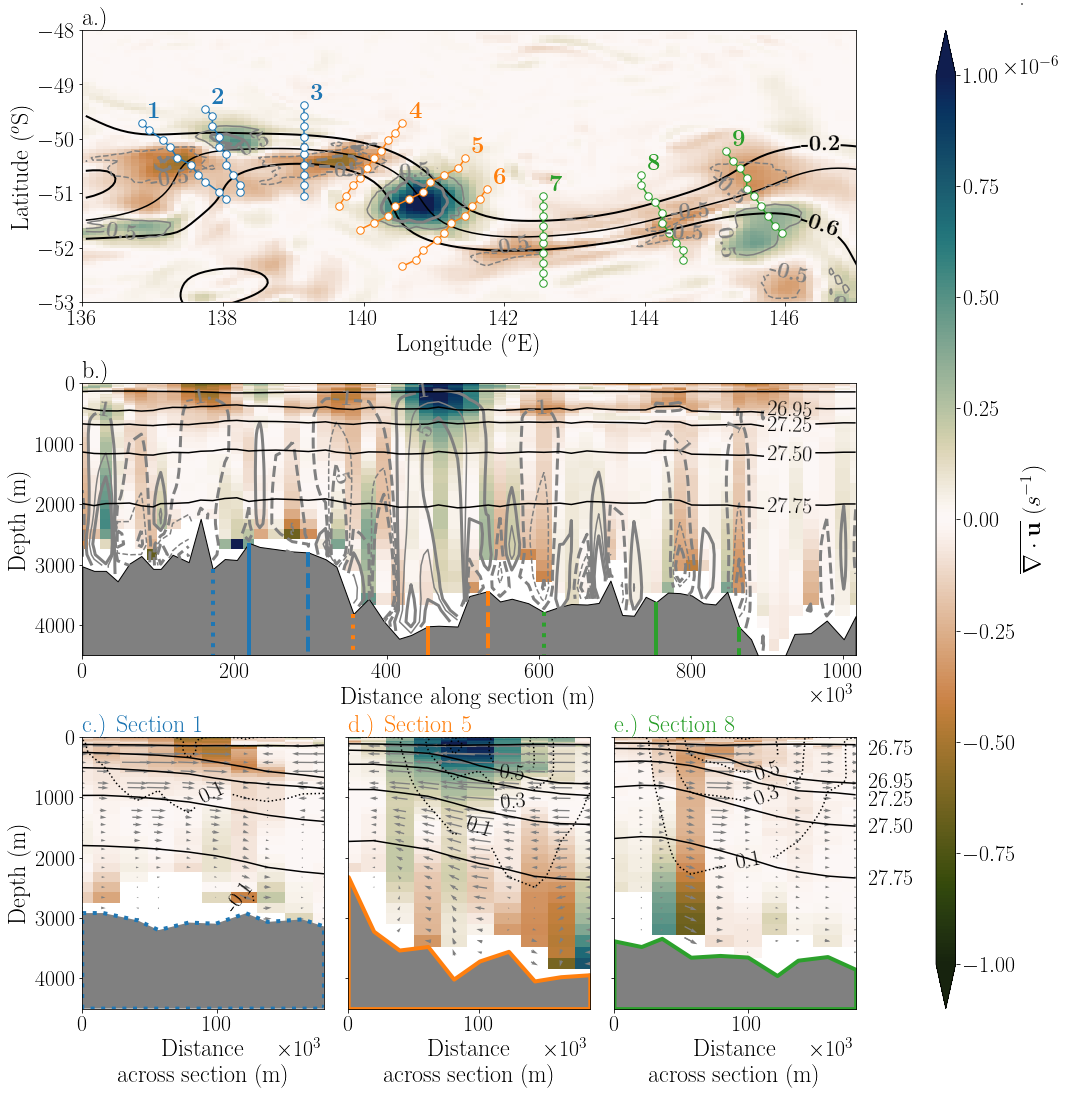

In [91]:
fig = plt.figure(figsize=(18,18), constrained_layout=True)
gs = plt.GridSpec(3, 3, hspace=0.3, wspace=0.1)
plt.subplot(gs[0, :]), plt.subplot(gs[1, :]), plt.subplot(gs[2, 0:1]), plt.subplot(gs[2, 1:2]), plt.subplot(gs[2, 2:])
ax = fig.get_axes()

cmap = cmo.cm.tarn
vmin, vmax = -1e-6, 1e-6

### 0) Plane view
pcol = ds.divu.isel(st_ocean=30).plot(ax=ax[0], cmap=cmo.cm.tarn, vmin=-1e-6, vmax=1e-6, add_colorbar=False)
ct_sl = ds.sea_level.plot.contour(ax=ax[0], colors='k', levels=sl_contours, linestyles='solid')
for ib, b in enumerate(sl_contours):
    if b in sl_contours[0::2]:
        zc = ct_sl.collections[ib]
        plt.setp(zc, linewidth=2)
ax[0].clabel(ct_sl, sl_contours[0::2], inline=1, fontsize=fs_small, fmt=r'{\bf %.1f}', manual=[(146.5, -50), (146.5, -51.5)])

ct_wt = (ds.wt.isel(st_ocean=30)*1e4).plot.contour(ax=ax[0], colors='gray', levels=w_levels[[0,1,3,4]])
plt.setp(ct_wt.collections[::3], linewidth=3)
ax[0].clabel(ct_wt, w_levels[1:-1:2], inline=True, fmt=r'{\bf %.1f}', fontsize=fs_small)

for its, (name, data) in enumerate(cross_sections.items()):
    ax[0].plot(data.xt_ocean, data.yt_ocean, '.-', color=cross_coords[name][1], markersize=15, markerfacecolor='w')
    ax[0].text(data.xt_ocean[-1]+.1, data.yt_ocean[-1]+.1, r'{\bf %s}' %(its+1), color=cross_coords[name][1], size=fs_large)

ax[0].set_ylim([-53, -48])
ax[0].set_xlim([136, 147])
ax[0].set_title('')
ax[0].set_xlabel(r'Longitude ($^o$E)', fontsize=fs_large)
ax[0].set_ylabel(r'Latitude ($^o$S)', fontsize=fs_large)
ax[0].text(0, 1.02, string.ascii_lowercase[0] + '.)',
           transform=ax[0].transAxes, size=fs_large, weight='bold')

### 1) Along Section
along_section.divu.plot(ax=ax[1], x='along-section', 
                        cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)

# vertical velocity contours
ct_wt = (along_section.wt*1e4).plot.contour(
    ax=ax[1], x='along-section', colors='gray', levels=wt_contours, add_labels=False)
for ic in [0,2,3,5]:
    plt.setp(ct_wt.collections[ic], linewidth=3)

# density contours
cont = along_section.sigma0.plot.contour(ax=ax[1], x='along-section', levels=density_levels, colors='k')
manual = [(930e3, 450), (930e3, 650), (930e3, 1150), (930e3, 2000)]
ax[1].clabel(cont, inline=1, fmt='%.2f', inline_spacing=10, fontsize=fs_small, manual=manual)

# depth contour
ax[1].fill_between(
    along_section['along-section'], along_section.ht, 5000, fc='gray', ec='k')

ax[1].set_xlim([along_section['along-section'].min(), along_section['along-section'].max()])

# position cross-sections vertical lines
for (coord, color, style) in cross_coords.values():
    ax[1].vlines(coord, ymin=ds.ht.sel(xt_ocean=coord.xt_ocean, yt_ocean=coord.yt_ocean, method='nearest').values, 
                    ymax=5000, color=color, lw=4, linestyle=style)

ax[1].set_xlabel(r'Distance along section (m)', fontsize=fs_large)

### 2) Cross Sections
z = ds.st_ocean
zi = np.linspace(z[0].values, z[-1].values, len(z))
idx = np.arange(len(cross_sections[name].st_ocean))
idxi = np.interp(zi, z, idx).astype('int')

manual_locations = {
    0: [(75e3, 2500), (100e3, 1000)],
    1: [(100e3, 1500), (125e3, 1000), (125e3, 500)],
    2: [(100e3, 2000), (115e3, 1000), (115e3, 500)],
}
sections = ['cross_section_trough', 'cross_section_between2', 'cross_section_crest2']
ct = []
iax = 1
for isec, section in enumerate(cross_sections.keys()):
    if section in sections:
        iax += 1
        # css[isec] = cross_sections[section]
        data = cross_sections[section]
        data.divu.plot(ax=ax[iax], x='cross-section', 
                                       cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)
        
        # cross front velocity vectors
        scale = 1e-5
        quiv = data.isel(st_ocean=idxi[::2]).plot.quiver(ax=ax[iax], color='gray',
            x='cross-section', y='st_ocean', u='vn', v='wt_inv', angles='xy', scale_units='xy', width=3e-4*fig.get_size_inches()[0], scale=scale)
        
        # density contours
        cont = data.sigma0.plot.contour(ax=ax[iax], x='cross-section', levels=density_levels, colors='k')
        
        # along front velocity
        ct.append(data.ut.plot.contour(ax=ax[iax], x='cross-section', colors='k', levels=ut_contours, linestyles='dotted'))

        # topography
        ax[iax].fill_between(data['cross-section'], data.ht, 4500,
                              fc='gray', ec=cross_coords[section][1], lw=4, linestyle=cross_coords[section][2])

        ax[iax].set_xlim([data['cross-section'].min(), data['cross-section'].max()])
        # ax[iax].set_ylim([0,4500])
        # ax[iax].invert_yaxis()

        # manual = [(160e3, 150), (160e3, 650), (160e3, 900), (160e3, 1300), (160e3, 2100), ]
        # ax[iax].clabel(cont, inline=1, fmt='%.2f', inline_spacing=10, fontsize=fs_small, use_clabeltext=True, manual=manual)
        
        # labelling
        ax[iax].text(0, 1.02, string.ascii_lowercase[iax] + '.) Section %s' %(isec+1),
                     transform=ax[iax].transAxes, size=fs_large, weight='bold', color=cross_coords[section][1])
        
for iax in range(1, len(ax)):
    
#     r, c = iax // ncols, iax % ncols
    ax[iax].ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
    ax[iax].set_ylabel(r'Depth (m)', fontsize=fs_large)
    if iax > 1:
        ax[iax].set_xlabel('Distance \n across section (m)', fontsize=fs_large)
    if iax > 2:
        ax[iax].set_ylabel('')
        ax[iax].set_yticklabels('')
    ax[iax].set_ylim([0,4500])
    ax[iax].invert_yaxis()
    
    # labelling
    if iax < 2:
        ax[iax].text(0, 1.02, string.ascii_lowercase[iax] + '.)',
                     transform=ax[iax].transAxes, size=fs_large, weight='bold')
        
manual = [(30e3, 500), (150e3, 250), (340e3, 700), (340e3, 1500), (450e3, 150), (460e3, 800), (600e3, 500), (790e3, 1000), (840e3, 600)]
ax[1].clabel(ct_wt, wt_contours[[0,2,3,5]], inline=True, fmt=r'{\bf %d}', fontsize=fs_small, manual=manual)
    
cbar = fig.colorbar(pcol, ax=ax, aspect=50, pad=0.08, extend='both')
cbar.ax.set_ylabel(r'$\overline{\bf \nabla_H \cdot u}~(s^{-1}$)', fontsize=fs_large)
cbar.ax.yaxis.set_offset_position('left')
cbar.ax.yaxis.get_offset_text().set_position((3.5,2))

# ax[1].clabel(ct_wt, wt_contours[2:-2], inline=True, fmt='%.0e', fontsize=fs_large)
for isec, section in enumerate(sections):
    ax[iax].clabel(ct[isec], inline=1, fmt='%.1f', inline_spacing=10, fontsize=fs_small, use_clabeltext=True, manual=manual_locations[isec])

qk = plt.quiverkey(quiv, 0.8, 1.0, scale, r'$%.0e~\mathrm{ms}^{-1}$' %scale, labelpos='E', coordinates='figure', 
                   fontproperties={'size': fs_large})

wm = {'26.75': (190e3, 200), 
      '26.95': (190e3, 750), 
      '27.25': (190e3, 1050), 
      '27.50': (190e3, 1500),
      '27.75': (190e3, 2350)}
for key, [x, y] in wm.items():
    ax[4].text(x, y, key, fontsize=fs_small, verticalalignment='center')

In [93]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        transparent = True if extension == '.png' else False
        fig.savefig(os.path.join(figsdir, '07_hor-divergence' + extension), 
                    transparent=transparent, bbox_inches='tight')

In [1]:
var = 'divu'
vmin, vmax = -1e-6, 1e-6
cmap=cmo.cm.tarn

nrows, ncols = 3, 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,18), constrained_layout=True, sharey=True)

for iax, (name, data) in enumerate(cross_sections.items()):

    r, c = iax // ncols, iax % ncols

    # vertical along and cross sectional velocities
    pcol = cross_sections[name][var].plot(ax=ax[r, c], x='cross-section', cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)
    ct = cross_sections[name].ut.plot.contour(ax=ax[r, c], x='cross-section', colors='k', levels=ut_contours, linestyles='dotted')
    ax[r, c].clabel(ct, inline=1, fmt='%.1f', inline_spacing=10, use_clabeltext=True)

    cross_sections[name].sel(st_ocean=slc).plot.quiver(ax=ax[r, c], color='gray',
        x='cross-section', y='st_ocean', u='vn', v='wt_inv', angles='xy', scale_units='xy', scale=1e-5)

    # density contours
    cont = cross_sections[name].sigma0.plot.contour(ax=ax[r, c], x='cross-section', levels=density_levels, colors='k')
    ax[r, c].clabel(cont, inline=1, fmt='%.1f', inline_spacing=10, use_clabeltext=True)

    # topography
    ax[r, c].fill_between(cross_sections[name]['cross-section'], cross_sections[name].ht, 4500,
                          fc='gray', ec=cross_coords[name][1], 
                          lw=4, linestyle=cross_coords[name][2])
    
    ax[r, c].set_ylim([0,4500])
    ax[r, c].invert_yaxis()
    
    ax[r, c].set_xlabel('')
    ax[r, c].set_ylabel('')

NameError: name 'cmo' is not defined